In [ ]:
!pip install mne

import pandas as pd
import numpy as np 
import mne
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sklearn.decomposition import FastICA
import pywt

import tensorflow as tf 
from tensorflow import keras
from keras.models import Model

!pip install pyts
from pyts.image import GramianAngularField

In [ ]:
m = loadmat('/content/drive/MyDrive/Brain Computer Interface/data/train_subject1_raw02.mat')
m.keys()

x = m['X']
y = m['Y']

print('shape of X:',x.shape)
print('Shape of Y:',y.shape)

from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(y)
print(onehot_encoded.shape)

shape of X: (121856, 32)
Shape of Y: (121856, 1)
(121856, 3)


In [ ]:
transformer = FastICA()
X_transformed = transformer.fit_transform(x)
X_transformed.shape

(121856, 32)

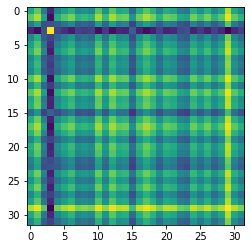

In [ ]:
gaf = GramianAngularField(image_size = 32)
im_train = gaf.transform(X_transformed)

plt.imshow(im_train[1000])
plt.show()

In [ ]:
im_train = np.repeat(im_train[..., np.newaxis], 3, -1)
im_train.shape

(121856, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


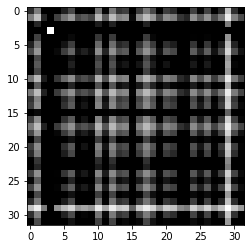

In [ ]:
plt.imshow(im_train[1000])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(im_train, onehot_encoded, train_size=0.7, random_state=7)
X_train.shape

(85299, 32, 32, 3)

In [ ]:
import tensorflow as tf 
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling3D, Activation, TimeDistributed,Flatten,LSTM,ConvLSTM2D, MaxPooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [ ]:
model = keras.Sequential()
model.add(VGG16(weights ='imagenet',include_top = False, input_shape=(32,32,3)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(4))
model.add(Dense(32,activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 time_distributed (TimeDistr  (None, 1, 512)           0         
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 12)                25200     
                                                                 
 dense (Dense)               (None, 3)                 39        
                                                                 
Total params: 14,739,927
Trainable params: 14,739,927
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 50
batch_size = 64

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,validation_split=0.3)

Epoch 1/50
933/933 [==============================] - 88s 91ms/step - loss: 0.9118 - accuracy: 0.6182 - val_loss: 0.7259 - val_accuracy: 0.7261
Epoch 2/50
933/933 [==============================] - 82s 88ms/step - loss: 0.6162 - accuracy: 0.7308 - val_loss: 0.5443 - val_accuracy: 0.7383
Epoch 3/50
933/933 [==============================] - 82s 88ms/step - loss: 0.5039 - accuracy: 0.7511 - val_loss: 0.4455 - val_accuracy: 0.8348
Epoch 4/50
933/933 [==============================] - 82s 88ms/step - loss: 0.3280 - accuracy: 0.9150 - val_loss: 0.1672 - val_accuracy: 0.9832
Epoch 5/50
933/933 [==============================] - 82s 88ms/step - loss: 0.1188 - accuracy: 0.9852 - val_loss: 0.0779 - val_accuracy: 0.9910
Epoch 6/50
933/933 [==============================] - 83s 89ms/step - loss: 0.0604 - accuracy: 0.9914 - val_loss: 0.1215 - val_accuracy: 0.9689
Epoch 7/50
933/933 [==============================] - 81s 87ms/step - loss: 0.0392 - accuracy: 0.9933 - val_loss: 0.0345 - val_accuracy:

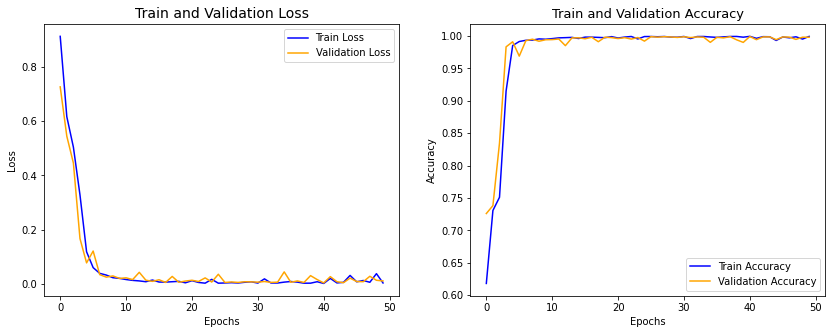

In [ ]:
epochs = [i for i in range(50)]
loss_train = history.history['loss']
acc_train = history.history['accuracy']
loss_test = history.history['val_loss']
acc_test = history.history['val_accuracy']


fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].plot(epochs, loss_train, color='blue', label='Train Loss')
ax[0].plot(epochs, loss_test, color='orange', label='Validation Loss')
ax[0].set_title('Train and Validation Loss', fontsize=14)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()



ax[1].plot(epochs, acc_train, color='blue', label='Train Accuracy')
ax[1].plot(epochs, acc_test, color='orange',  label='Validation Accuracy')
ax[1].set_title('Train and Validation Accuracy', fontsize=13)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

In [ ]:
import time 
s1 = time.time()
y_pred = model.predict(X_test)
s2 = time.time()
s = s2 -s1 
print(s)

21.591201782226562


In [ ]:
import numpy as np
y_predict_non_category = [ np.argmax(t) for t in y_pred ]
y_test_non_category = [np.argmax(t) for t in y_test]

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test_non_category, y_predict_non_category)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_non_category, y_predict_non_category)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_non_category, y_predict_non_category, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_non_category, y_predict_non_category, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_non_category, y_predict_non_category, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_non_category, y_predict_non_category, average='macro')))

print('Macro Recall: {:.2f}'.format(recall_score(y_test_non_category, y_predict_non_category, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_non_category, y_predict_non_category, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_non_category, y_predict_non_category, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_non_category,y_predict_non_category, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_non_category, y_predict_non_category, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_non_category, y_predict_non_category, target_names=['Class 1', 'Class 2', 'Class 3']))

Confusion Matrix

[[ 9153    11    11]
 [    3 14206    24]
 [    4     5 13140]]

Accuracy: 1.00

Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00

Classification Report

              precision    recall  f1-score   support

     Class 1       1.00      1.00      1.00      9175
     Class 2       1.00      1.00      1.00     14233
     Class 3       1.00      1.00      1.00     13149

    accuracy                           1.00     36557
   macro avg       1.00      1.00      1.00     36557
weighted avg       1.00      1.00      1.00     36557



Text(0.5, 257.44, 'Predicted label')

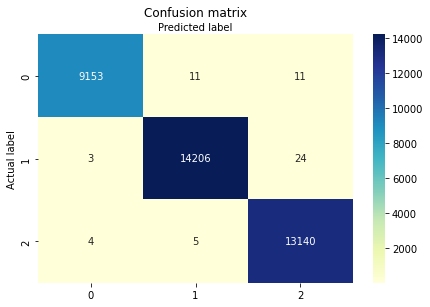

In [ ]:
import seaborn as sns
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test_non_category, y_predict_non_category)
cnf_matrix
%matplotlib inline
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

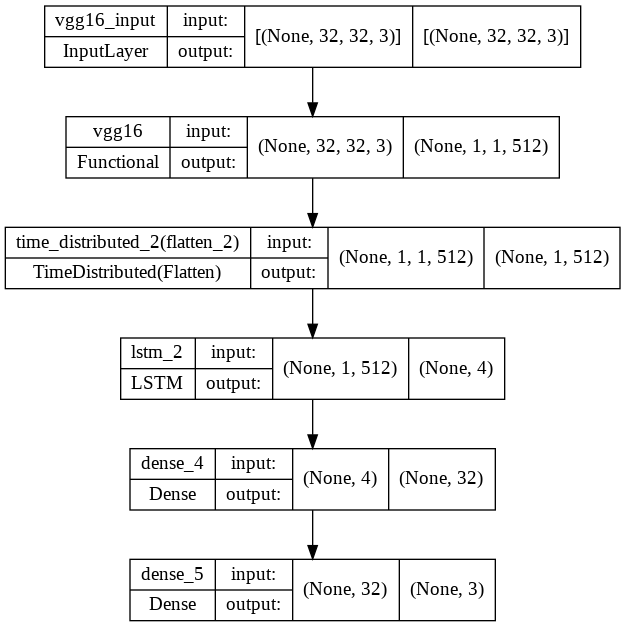

In [ ]:
import tensorflow as tf
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

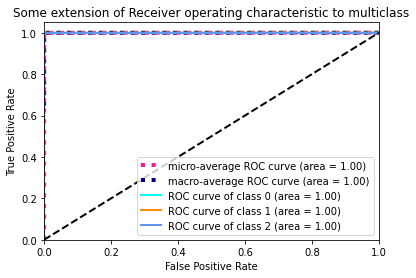

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(3), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()